IMPORTS

In [104]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tqdm.keras import TqdmCallback
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

RESNET MODEL STRUCTURE

In [99]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-5]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

DATASET PREPROCESSING

In [105]:
venomous_classes = ["barredcoral snake", "king cobra", "north ph temple pitviper"]

def csv_to_binary_labels(csv_path, image_dir):
    df = pd.read_csv(csv_path)

    class_cols = df.columns[1:]  # skip filename
    df["label"] = df[class_cols].idxmax(axis=1)

    df["binary_label"] = df["label"].apply(lambda x: 1 if x in venomous_classes else 0)

    # Create the final binary DataFrame
    df_binary = df[["filename", "binary_label"]].copy()
    df_binary["filename"] = df_binary["filename"].apply(lambda x: f"{image_dir}/{x}")

    # ✅ Make sure labels are strings for class_mode='binary'
    df_binary["binary_label"] = df_binary["binary_label"].astype(str)

    return df_binary


DATA AUGMENTATION

In [106]:
# Image size and batch size
img_size = (224, 224)
batch_size = 16

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess_input)

TRAIN AND VALIDATION DATAFRAME GENERATOR

In [108]:
datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess_input)

train_df = csv_to_binary_labels("../dataset/train/_classes.csv", "../dataset/train")
val_df   = csv_to_binary_labels("../dataset/valid/_classes.csv", "../dataset/valid")

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",  # gives [0] or [1] directly
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)


Found 6176 validated image filenames belonging to 2 classes.
Found 1768 validated image filenames belonging to 2 classes.


DEFINING CLASS WEIGHTS

In [109]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['binary_label']),
    y=train_df['binary_label']
)
class_weights = dict(enumerate(class_weights))

MODEL TRAINING

In [44]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10


c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


386/386 ━━━━━━━━━━━━━━━━━━━━ 292s 729ms/step - accuracy: 0.7130 - loss: 0.5827 - precision_5: 0.7252 - recall_5: 0.7150 - val_accuracy: 0.8801 - val_loss: 0.2898 - val_precision_5: 0.9324 - val_recall_5: 0.8319
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 269s 697ms/step - accuracy: 0.9137 - loss: 0.2365 - precision_5: 0.9222 - recall_5: 0.9174 - val_accuracy: 0.9276 - val_loss: 0.1925 - val_precision_5: 0.9107 - val_recall_5: 0.9558
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 266s 690ms/step - accuracy: 0.9593 - loss: 0.1305 - precision_5: 0.9612 - recall_5: 0.9628 - val_accuracy: 0.9412 - val_loss: 0.1602 - val_precision_5: 0.9714 - val_recall_5: 0.9149
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 262s 678ms/step - accuracy: 0.9819 - loss: 0.0752 - precision_5: 0.9835 - recall_5: 0.9825 - val_accuracy: 0.9638 - val_loss: 0.1208 - val_precision_5: 0.9747 - val_recall_5: 0.9558
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 264s 683ms/step - accuracy: 0.9909 - loss: 0.0454 - precision_5: 0.9891 - recall_5:

SAVING THE MODEL FOR ENSEMBLING

In [45]:
# Save the trained model
model.save('resnet50_finetuned_model.h5')  # Save the entire model
print("Model saved successfully as resnet50_finetuned_model.h5")

Model saved successfully as resnet50_finetuned_model.h5


TESTING DATAFRAME GENERATOR

In [ ]:
test_df  = csv_to_binary_labels("../dataset/test/_classes.csv", "../dataset/test") 

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

Found 1768 validated image filenames belonging to 2 classes.
Found 1334 validated image filenames belonging to 2 classes.


DATA VALIDATION METRICS

In [79]:
# Evaluate the Model on Validation Data
validation_scores = model.evaluate(validation_generator)
print("Validation Accuracy: {:.2f}%".format(validation_scores[1] * 100))
print("Validation Precision: {:.2f}%".format(validation_scores[2] * 100))
print("Validation Recall: {:.2f}%".format(validation_scores[3] * 100))

111/111 ━━━━━━━━━━━━━━━━━━━━ 64s 567ms/step - accuracy: 0.9694 - loss: 0.1124 - precision_5: 0.9570 - recall_5: 0.9852
Validation Accuracy: 96.95%
Validation Precision: 95.90%
Validation Recall: 98.38%


DATA TEST METRICS

In [93]:
# Evaluate the Model on Test Data
test_scores = model.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_scores[1] * 100))
print("Test Precision: {:.2f}%".format(test_scores[2] * 100))
print("Test Recall: {:.2f}%".format(test_scores[3] * 100))

c:\Users\ivanne bayer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 555ms/step - accuracy: 0.8225 - loss: 0.7528 - precision_5: 0.8026 - recall_5: 0.8696
Test Accuracy: 81.18%
Test Precision: 79.21%
Test Recall: 84.56%


GENERATING PREDICTIONS 

In [94]:
# Generate predictions
test_generator.reset()
y_pred = model.predict(test_generator).flatten()
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_df["binary_label"].values
y_true = [int(label) for label in y_true]

84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 560ms/step


RESNET TEST DATA CONFUSION MATRIX

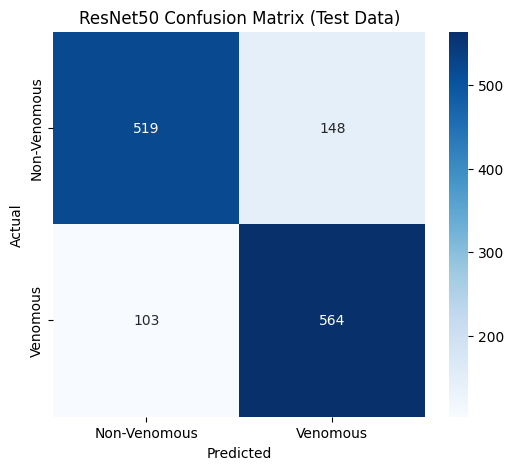

In [95]:
# Confusion Matrix for Test Data
cm_test = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Venomous", "Venomous"],
            yticklabels=["Non-Venomous", "Venomous"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('ResNet50 Confusion Matrix (Test Data)')
plt.show()

In [8]:
import pandas as pd

# Load CSV
csv_path = "../dataset/test/_classes.csv"
df = pd.read_csv(csv_path)

# Count how many images (rows)
num_images = len(df)

print(f"Number of images in {csv_path}: {num_images}")


Number of images in ../dataset/test/_classes.csv: 528
